<a href="https://colab.research.google.com/github/andreacohen7/tourism/blob/main/Titanic_Survival_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Titanic Survival Predictions
- Andrea Cohen
- 01.20.23

## Task
  - To build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

## Data:
- Source -- https://www.kaggle.com/competitions/titanic/data?select=train.csv


## Data Dictionary:

Variable |	Definition (Key)
---| ---
survival |	Survival	(0 = No, 1 = Yes)
pclass |	Ticket class	(1 = 1st, 2 = 2nd, 3 = 3rd)
sex |	Sex	
Age |	Age in years	
sibsp |	# of siblings / spouses aboard the Titanic	
parch |	# of parents / children aboard the Titanic	
ticket |	Ticket number	
fare |	Passenger fare	
cabin |	Cabin number	
embarked |	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

Variable Notes:

- pclass:   
A proxy for socio-economic status (SES)
  - 1st = Upper
  - 2nd = Middle
  - 3rd = Lower

- age:   
Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

- sibsp:   
The dataset defines family relations in this way...
  - Sibling = brother, sister, stepbrother, stepsister
  - Spouse = husband, wife (mistresses and fiancés were ignored)

- parch:   
The dataset defines family relations in this way...
  - Parent = mother, father
  - Child = daughter, son, stepdaughter, stepson
  - Some children travelled only with a nanny, therefore parch=0 for them.


### Preliminary Steps

#### Mount the drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Import libraries

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, plot_confusion_matrix
from sklearn import set_config
set_config(display='diagram')

### Load and inspect the data

#### Load the dataset

In [45]:
# load the dataset and check for unnecessary columns
df = pd.read_csv('/content/train.csv')
display(df.head())
display(df.info())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


None

  - PassengerID, Name, and Ticket probably have no predictive value for survival.  These columns can be dropped.

In [46]:
df = df.drop(columns = ['PassengerId', 'Name', 'Ticket'])
display(df.head())
display(df.info())

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,NaN,S
1,1,1,female,38.0,1,0,71.2833,C85,C
2,1,3,female,26.0,0,0,7.9250,NaN,S
3,1,1,female,35.0,1,0,53.1000,C123,S
4,0,3,male,35.0,0,0,8.0500,NaN,S


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Cabin     204 non-null    object 
 8   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(3)
memory usage: 62.8+ KB


None

  - There are no other unnecessary columns.

#### Inspect and clean the data

In [47]:
df.shape

(891, 9)

  - There are 891 rows and 9 columns.

In [48]:
# check datatypes and ensure that they match the data dictionary
df.dtypes

Survived      int64
Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Cabin        object
Embarked     object
dtype: object

  - Sex, Cabin, and Embarked are all datatype object.
  - Survived, Pclass, SibSp, and Parch are all datatype int64.
  - Age and Fare are all datatype float64.
  - All datatypes are consistent with the data dictionary.

In [49]:
# check for outliers and obvious errors
display(df.describe(include='number'))
display(df.describe(exclude='number'))

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


,Sex,Cabin,Embarked
count,891,204,889
unique,2,147,3
top,male,B96 B98,S
freq,577,4,644


  - There are no obvious outliers or errors in the data.

In [50]:
# check for duplicated rows
df.duplicated().sum()

107

  - There are 107 duplicates.

In [51]:
# drop duplicate rows
df = df.drop_duplicates()
df.duplicated().sum()

0

  - There are now 0 duplicates.

In [52]:
# check for missing values
df.isna().sum()

Survived      0
Pclass        0
Sex           0
Age         106
SibSp         0
Parch         0
Fare          0
Cabin       581
Embarked      2
dtype: int64

  - There are 106 missing values in Age.
  - Options:
    - Dropping rows is not a good option because 13.52% of rows are missing data--too many (>2%) to just eliminate.  
    - Dropping columns is not a good option because Age might be an important property for predicting survival. Also, <50% of the data are missing, too little to just eliminate.  
    - Creating a new category is not a good option because the data are type float instead of type object.  
    - Imputing missing values is a great option because the average (mean) value would likely be closest to the correct value that is missing.
  - Mean imputation will be performed on a copy of the dataset for machine learning--this imputation will be performed within a pipeline in order to prevent data leakage.

  - There are 581 missing values in Cabin.
  - Options:
    - Dropping rows was not a good option because 74.11% of rows are missing data--too many (>2%) to just eliminate.
    - Imputing missing values is not a good option because there are so few values that the most frequent value would be unlikely to be the correct value that is missing.
    - Creating a new category is an option because there might be some predictive value in a 'Missing' category.
    - Dropping the column is a better option because >50% of the data are missing, which limits the predictive value of the category.  

In [53]:
# drop the 'Cabin' column
df = df.drop(columns = 'Cabin')
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [54]:
# check the categorical data for inconsistencies
dtypes = df.dtypes
str_cols = dtypes[dtypes=='object'].index
for col in str_cols:
  print(f'Column= {col}')
  print(df[col].value_counts())
  print(' ')

Column= Sex
male      491
female    293
Name: Sex, dtype: int64
 
Column= Embarked
S    568
C    155
Q     59
Name: Embarked, dtype: int64
 


  - There are no inconsistencies in categorical data.
  - For machine learning, categorical data will be one-hot encoded.

In [55]:
# check the balance of the target class
df['Survived'].value_counts(normalize=True)

0    0.58801
1    0.41199
Name: Survived, dtype: float64

  - The target classes are mildly imbalanced (58.801% of the samples did not survive and 41.199% of the samples survived).

### Univariate visualizations

#### Graph to view the distribution of the target class

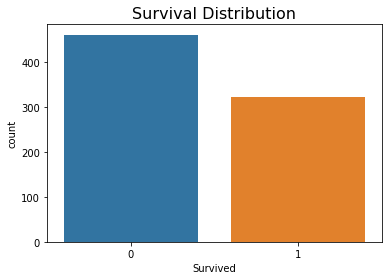

In [56]:
sns.countplot(data = df, x = 'Survived')
plt.title('Survival Distribution', fontsize = 16);

  - The target class is mildly imbalanced--there were fewer survivors than not.


#### Graphs to view passenger characteristics

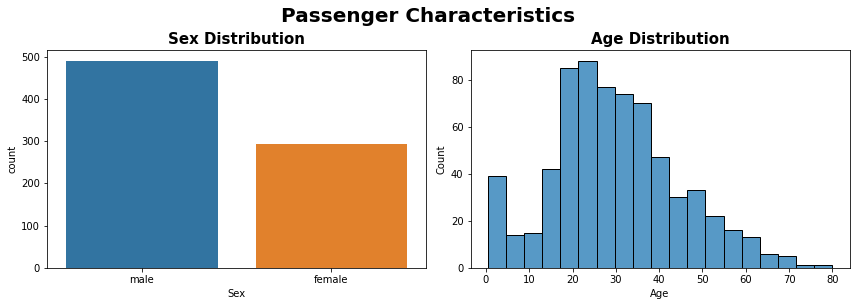

In [57]:
fig, axes = plt.subplots(ncols = 2, figsize = (12,4))
sns.countplot(data = df, x = 'Sex',  ax = axes[0])
axes[0].set_title('Sex Distribution', fontsize = 15, fontweight = 'bold')
sns.histplot(data = df, x = 'Age', ax = axes[1])
axes[1].set_title('Age Distribution', fontsize = 15, fontweight = 'bold')
fig.suptitle('Passenger Characteristics', fontsize = 20, fontweight = 'bold', y = 1.05)
fig.tight_layout()

  - There were siginificantly more male passengers than female passengers.
  - The age distribution of passengers was mildly right-skewed--most of the passengers were in their 20's and 30's, with a small spike in passengers younger than 4. 

#### Graphs to view family characteristics

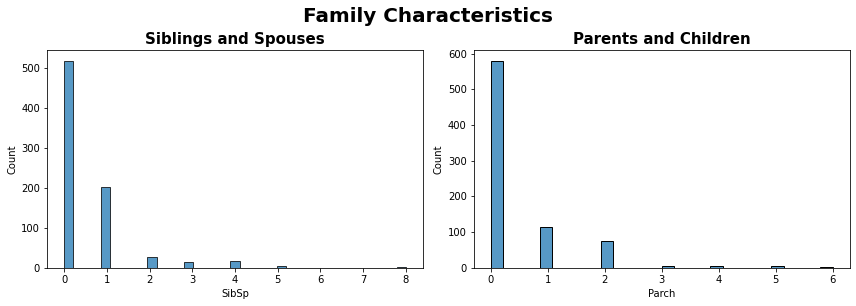

In [58]:
fig, axes = plt.subplots(ncols = 2, figsize = (12, 4))
sns.histplot(data = df, x = 'SibSp',  ax = axes[0])
axes[0].set_title('Siblings and Spouses', fontsize = 15, fontweight = 'bold')
sns.histplot(data = df, x = 'Parch', ax = axes[1])
axes[1].set_title('Parents and Children', fontsize = 15, fontweight = 'bold')
fig.suptitle('Family Characteristics', fontsize = 20, fontweight = 'bold', y = 1.05)
fig.tight_layout()

  - The family distributions were both right-skewed--the majority of passengers had 0 siblings and spouses and had 0 parents and children.

#### Graphs to view socio-economic characteristics

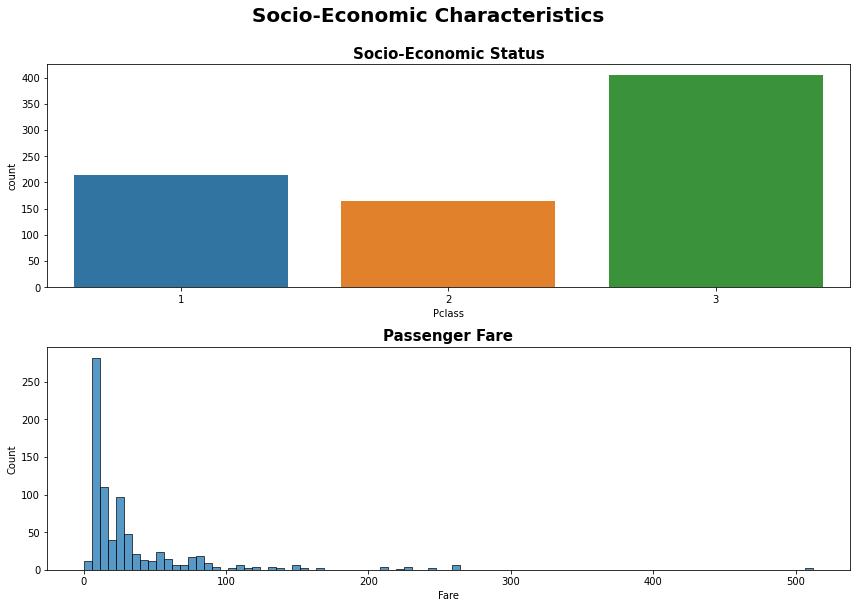

In [59]:
fig, axes = plt.subplots(ncols = 1, nrows = 2, figsize = (12, 8))
sns.countplot(data = df, x = 'Pclass',  ax = axes[0])
axes[0].set_title('Socio-Economic Status', fontsize = 15, fontweight = 'bold')
sns.histplot(data = df, x = 'Fare', ax = axes[1])
axes[1].set_title('Passenger Fare', fontsize = 15, fontweight = 'bold')
fig.suptitle('Socio-Economic Characteristics', fontsize = 20, fontweight = 'bold', y = 1.05)
fig.tight_layout()

  - The majority of passengers were lower socioeconomic class.
  - The distribution of passenger fares was right skewed, with the majority of tickets sold at lower fares.

#### Graph to view the place of embarcation

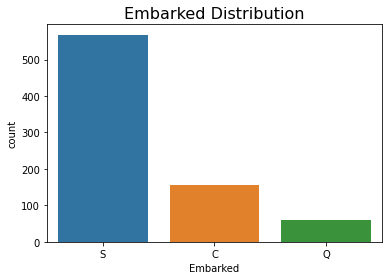

In [60]:
sns.countplot(data = df, x = 'Embarked')
plt.title('Embarked Distribution', fontsize = 16);

  - The majority of passengers embarked at Southampton.

#### Boxplots to view outliers

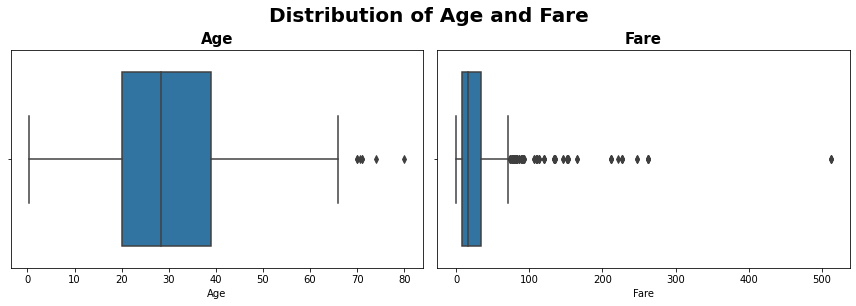

In [61]:
fig, axes = plt.subplots(ncols = 2, figsize = (12,4))
sns.boxplot(data = df, x = 'Age',  ax = axes[0])
axes[0].set_title('Age', fontsize = 15, fontweight = 'bold')
sns.boxplot(data = df, x = 'Fare', ax = axes[1])
axes[1].set_title('Fare', fontsize = 15, fontweight = 'bold')
fig.suptitle('Distribution of Age and Fare', fontsize = 20, fontweight = 'bold', y = 1.05)
fig.tight_layout()

  - Both the Age and the Passenger Fare distributions have outliers above the maximum values.

#### Correlation heatmap

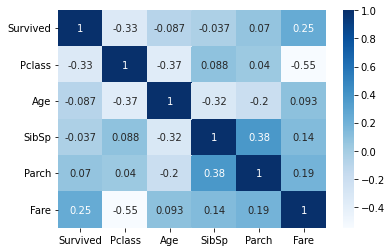

In [62]:
corr = df.corr()
sns.heatmap(corr, cmap = 'Blues', annot = True);

  - None of the features are strongly correlated with the target.

### Prepare the data for modeling

#### Arrange data into a features matrix and a target vector

In [63]:
X = df.drop(columns = 'Survived')
y = df['Survived']

#### Train test split (model validation)

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 42)

#### Create a preprocessing pipeline to use with the models.

In [65]:
#create a columntransformer for preprocessing
#prepare the preprocessing object but do not preprocess the data yet--the data will be preprocessed inside the model pipeline
#instantiate the transformers to impute missing values, one-hot encode the categorical data, and scale the numeric data
mean_imputer = SimpleImputer(strategy = 'mean')
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
scaler = StandardScaler()
#prepare a separate processing pipeline for categorical data
num_pipe = make_pipeline(mean_imputer, scaler)
#create columnselectors for the numeric and categorical data
cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')
#combine the pipelines and columnselectors into tuples for the columntransformer
cat_tuple = (ohe, cat_selector)
num_tuple = (num_pipe, num_selector)
#create the preprocessing columntransformer
preprocessor = make_column_transformer(cat_tuple, num_tuple, remainder='drop')
preprocessor

ColumnTransformer(transformers=[('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f6025cde610>),
                                ('pipeline',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f6025cde520>)])

### Dummy Classifier

In [66]:
#instantiate and fit the Dummy Classifier
dum = DummyClassifier(strategy = 'stratified', random_state=42)
dum_pipe = make_pipeline(preprocessor, dum)
dum_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f6025cde610>),
                                                 ('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f6025cde520>)])),
                ('dummyclassifier',
                 DummyClassifier(random_state=42, strategy='stratified'))])

In [67]:
#make predictions
train_preds_dum_pipe = dum_pipe.predict(X_train)
test_preds_dum_pipe = dum_pipe.predict(X_test)

In [68]:
#print classification reports for the training and the testing data
print('Dummy Classifier Classification Report for Training Data')
print(classification_report(y_train, train_preds_dum_pipe))
print('Dummy Classifier Classification Report for Testing Data')
print(classification_report(y_test, test_preds_dum_pipe))

Dummy Classifier Classification Report for Training Data
              precision    recall  f1-score   support

           0       0.59      0.57      0.58       346
           1       0.41      0.43      0.42       242

    accuracy                           0.51       588
   macro avg       0.50      0.50      0.50       588
weighted avg       0.52      0.51      0.51       588

Dummy Classifier Classification Report for Testing Data
              precision    recall  f1-score   support

           0       0.55      0.57      0.56       115
           1       0.36      0.35      0.35        81

    accuracy                           0.47       196
   macro avg       0.45      0.46      0.46       196
weighted avg       0.47      0.47      0.47       196



  - The Dummy Classifier is 47% accurate for making correct predictions on the test set.
  - It was more successful at classifying those who did not survive than those who did survive.


### XGBClassifier

In [69]:
#instantiate and fit XGBoost
xgb = XGBClassifier()
xgb_pipe = make_pipeline(preprocessor, xgb)
xgb_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f6025cde610>),
                                                 ('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f6025cde520>)])),
                ('xgbclassifier', XGBClassifier())])

In [70]:
#make predictions
train_preds_xgb_pipe = xgb_pipe.predict(X_train)
test_preds_xgb_pipe = xgb_pipe.predict(X_test)

In [71]:
#print classification reports for the training and the testing data
print('XGBoost Classification Report for Training Data')
print(classification_report(y_train, train_preds_xgb_pipe))
print('XGBoost Classification Report for Testing Data')
print(classification_report(y_test, test_preds_xgb_pipe))

XGBoost Classification Report for Training Data
              precision    recall  f1-score   support

           0       0.84      0.95      0.89       346
           1       0.90      0.74      0.81       242

    accuracy                           0.86       588
   macro avg       0.87      0.84      0.85       588
weighted avg       0.86      0.86      0.86       588

XGBoost Classification Report for Testing Data
              precision    recall  f1-score   support

           0       0.81      0.91      0.86       115
           1       0.85      0.70      0.77        81

    accuracy                           0.83       196
   macro avg       0.83      0.81      0.82       196
weighted avg       0.83      0.83      0.82       196



In [72]:
#check xgb_pipe parameters
xgb_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('onehotencoder',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse=False),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f6025cde610>),
                                   ('pipeline',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f6025cde520>)])),
  ('xgbclassifier', XGBClassifier())],
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('onehotencoder',
                                  OneHotEncode

In [73]:
#create a parameter grid dictionary
param_grid1 = {'xgbclassifier__max_depth': range(1, 10),
               'xgbclassifier__learning_rate': [.01, 0.1, 0.2],
              'xgbclassifier__gamma': [0, 5, 10],
              'xgbclassifier__min_child_weight': [0, 5, 10]}
#instantiate the GridSearchCV object
xgb_grid_search = GridSearchCV(xgb_pipe, param_grid1)
#fit the GridSearchCV object on the training data
xgb_grid_search.fit(X_train, y_train)
#find the best parameters
print(xgb_grid_search.best_params_)
#find the accuracy of the best model
best_xgb = xgb_grid_search.best_estimator_
print(f'Accuracy of best XGBClassifier model is: {best_xgb.score(X_test, y_test)}')

{'xgbclassifier__gamma': 5, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 3, 'xgbclassifier__min_child_weight': 0}
Accuracy of best XGBClassifier model is: 0.7857142857142857


  - Tuning the hyperparameters reduced the model's accuracy for making predictions on the test set.  

In [74]:
#make predictions using the tuned XGBoost model
xgb_tuned = XGBClassifier(max_depth = 3, learning_rate = 0.1, gamma = 5, min_child_weight = 0, random_state=42)
xgb_tuned_pipe = make_pipeline(preprocessor, xgb_tuned)
xgb_tuned_pipe.fit(X_train, y_train)
train_preds_xgb_tuned = xgb_tuned_pipe.predict(X_train)
test_preds_xgb_tuned = xgb_tuned_pipe.predict(X_test)

In [75]:
#compare the precision, recall, and f1-scores on the testing data for the original XGBoost model and the tuned XGBoost model
print('XGBoost Classification Report for Testing Data')
print(classification_report(y_test, test_preds_xgb_pipe))
print('Tuned XGBoost Classification Report for Testing Data')
print(classification_report(y_test, test_preds_xgb_tuned))

XGBoost Classification Report for Testing Data
              precision    recall  f1-score   support

           0       0.81      0.91      0.86       115
           1       0.85      0.70      0.77        81

    accuracy                           0.83       196
   macro avg       0.83      0.81      0.82       196
weighted avg       0.83      0.83      0.82       196

Tuned XGBoost Classification Report for Testing Data
              precision    recall  f1-score   support

           0       0.74      0.98      0.84       115
           1       0.95      0.51      0.66        81

    accuracy                           0.79       196
   macro avg       0.85      0.74      0.75       196
weighted avg       0.83      0.79      0.77       196



  - The tuned XGBoost model reduced the accuracy for making predictions on the test set, increased false negatives, and increased false positives.
  - The original XGBoost was a better predictive model for survival.

### LightGBM

In [76]:
#instantiate and fit LightGBM
lgbm = LGBMClassifier()
lgbm_pipe = make_pipeline(preprocessor, lgbm)
lgbm_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f6025cde610>),
                                                 ('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f6025cde520>)])),
                ('lgbmclassifier', LGBMClassifier())])

In [77]:
#make predictions
train_preds_lgbm_pipe = lgbm_pipe.predict(X_train)
test_preds_lgbm_pipe = lgbm_pipe.predict(X_test)

In [78]:
#print classification reports for the training and the testing data
print('LightGBM Classification Report for Training Data')
print(classification_report(y_train, train_preds_lgbm_pipe))
print('LightGBM Classification Report for Testing Data')
print(classification_report(y_test, test_preds_lgbm_pipe))

LightGBM Classification Report for Training Data
              precision    recall  f1-score   support

           0       0.89      0.96      0.92       346
           1       0.94      0.83      0.88       242

    accuracy                           0.91       588
   macro avg       0.91      0.90      0.90       588
weighted avg       0.91      0.91      0.91       588

LightGBM Classification Report for Testing Data
              precision    recall  f1-score   support

           0       0.82      0.89      0.85       115
           1       0.82      0.73      0.77        81

    accuracy                           0.82       196
   macro avg       0.82      0.81      0.81       196
weighted avg       0.82      0.82      0.82       196



In [79]:
#check lgbm_pipe parameters
lgbm_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('onehotencoder',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse=False),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f6025cde610>),
                                   ('pipeline',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f6025cde520>)])),
  ('lgbmclassifier', LGBMClassifier())],
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('onehotencoder',
                                  OneHotEnco

In [80]:
#create a parameter grid dictionary
param_grid2 = {'lgbmclassifier__num_leaves': [8, 21, 31, 100, 1000],
               'lgbmclassifier__max_depth': range(3, 12),
              'lgbmclassifier__learning_rate': [.01, 0.1, 0.2],
              'lgbmclassifier__class_weight': ['balanced', None]}
#instantiate the GridSearchCV object
lgbm_grid_search = GridSearchCV(lgbm_pipe, param_grid2)
#fit the GridSearchCV object on the training data
lgbm_grid_search.fit(X_train, y_train)
#find the best parameters
print(lgbm_grid_search.best_params_)
#find the accuracy of the best model
best_lgbm = lgbm_grid_search.best_estimator_
print(f'Accuracy of best LGBMClassifier model is: {best_lgbm.score(X_test, y_test)}')

{'lgbmclassifier__class_weight': None, 'lgbmclassifier__learning_rate': 0.1, 'lgbmclassifier__max_depth': 3, 'lgbmclassifier__num_leaves': 8}
Accuracy of best LGBMClassifier model is: 0.8214285714285714


  - Tuning the hyperparameters did not change the model's accuracy for making predictions on the test set.

In [81]:
#make predictions using the tuned LightGBM model
lgbm_tuned = LGBMClassifier(num_leaves = 8, max_depth = 3, learning_rate = 0.1, class_weight = None, random_state=42)
lgbm_tuned_pipe = make_pipeline(preprocessor, lgbm_tuned)
lgbm_tuned_pipe.fit(X_train, y_train)
train_preds_lgbm_tuned = lgbm_tuned_pipe.predict(X_train)
test_preds_lgbm_tuned = lgbm_tuned_pipe.predict(X_test)

In [83]:
#compare the precision, recall, and f1-scores on the testing data for the original LightGBM model and the tuned LightGBM model
print('LightGBM Classification Report for Testing Data')
print(classification_report(y_test, test_preds_lgbm_pipe))
print('Tuned LightGBM Classification Report for Testing Data')
print(classification_report(y_test, test_preds_lgbm_tuned))

LightGBM Classification Report for Testing Data
              precision    recall  f1-score   support

           0       0.82      0.89      0.85       115
           1       0.82      0.73      0.77        81

    accuracy                           0.82       196
   macro avg       0.82      0.81      0.81       196
weighted avg       0.82      0.82      0.82       196

Tuned LightGBM Classification Report for Testing Data
              precision    recall  f1-score   support

           0       0.81      0.90      0.86       115
           1       0.84      0.70      0.77        81

    accuracy                           0.82       196
   macro avg       0.83      0.80      0.81       196
weighted avg       0.82      0.82      0.82       196



  - The tuned LightGBM model maintained the accuracy for making predictions on the test set, mildly decreased true negatives, mildly decreased true positives, mildly increased false negatives, mildly increased false positives, mildly increased the f1-score for the negative class, and maintained the f1-score for the positive class.
  - Because the overall accuracy was the same for both models, the decreases of true negatives and true positives was not worth the increases in false negatives and false positives through tuning.
  - The original LightGBM model was a better predictive model for survival.

### GradientBoostingClassifier

In [84]:
#instantiate and fit gradient boosting classifier
gbc = GradientBoostingClassifier()
gbc_pipe = make_pipeline(preprocessor, gbc)
gbc_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f6025cde610>),
                                                 ('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f6025cde520>)])),
                ('gradientboostingclassifier', GradientBoostingClassifier())])

In [85]:
#make predictions
train_preds_gbc_pipe = gbc_pipe.predict(X_train)
test_preds_gbc_pipe = gbc_pipe.predict(X_test)

In [86]:
#print classification reports for the training and the testing data
print('Gradient Boosting Classifier Classification Report for Training Data')
print(classification_report(y_train, train_preds_gbc_pipe))
print('Gradient Boosting Classifier Classification Report for Testing Data')
print(classification_report(y_test, test_preds_gbc_pipe))

Gradient Boosting Classifier Classification Report for Training Data
              precision    recall  f1-score   support

           0       0.85      0.97      0.91       346
           1       0.94      0.76      0.84       242

    accuracy                           0.88       588
   macro avg       0.90      0.86      0.87       588
weighted avg       0.89      0.88      0.88       588

Gradient Boosting Classifier Classification Report for Testing Data
              precision    recall  f1-score   support

           0       0.81      0.91      0.86       115
           1       0.85      0.70      0.77        81

    accuracy                           0.83       196
   macro avg       0.83      0.81      0.82       196
weighted avg       0.83      0.83      0.82       196



In [87]:
#check gbc_pipe parameters
gbc_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('onehotencoder',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse=False),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f6025cde610>),
                                   ('pipeline',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f6025cde520>)])),
  ('gradientboostingclassifier', GradientBoostingClassifier())],
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('onehotencoder',
                    

In [88]:
#create a parameter grid dictionary
param_grid3 = {'gradientboostingclassifier__learning_rate': [1, 0.5, 0.25, 0.1, 0.05, 0.01],
               'gradientboostingclassifier__n_estimators': [1, 2, 4, 8, 16, 32, 64, 100, 200],
              'gradientboostingclassifier__max_depth': [1, 3, 32],
              'gradientboostingclassifier__min_samples_split': [0.1, 1.0, 2, 10],
               'gradientboostingclassifier__min_samples_leaf': [0.1, 1, 0.5, 5]}
#instantiate the GridSearchCV object
gbc_grid_search = GridSearchCV(gbc_pipe, param_grid3)
#fit the GridSearchCV object on the training data
gbc_grid_search.fit(X_train, y_train)
#find the best parameters
print(gbc_grid_search.best_params_)
#find the accuracy of the best model
best_gbc = gbc_grid_search.best_estimator_
print(f'Accuracy of best GradientBoostingClassifier model is: {best_gbc.score(X_test, y_test)}')

{'gradientboostingclassifier__learning_rate': 0.1, 'gradientboostingclassifier__max_depth': 3, 'gradientboostingclassifier__min_samples_leaf': 1, 'gradientboostingclassifier__min_samples_split': 10, 'gradientboostingclassifier__n_estimators': 32}
Accuracy of best GradientBoostingClassifier model is: 0.8163265306122449


  - Tuning the hyperparameters decreased the model's accuracy for making predictions on the test set.

In [89]:
#make predictions using the tuned GradientBoostingClassifier model
gbc_tuned = GradientBoostingClassifier(learning_rate = 0.1, n_estimators = 32, max_depth = 3, min_samples_split = 10, min_samples_leaf = 1, random_state=42)
gbc_tuned_pipe = make_pipeline(preprocessor, gbc_tuned)
gbc_tuned_pipe.fit(X_train, y_train)
train_preds_gbc_tuned = gbc_tuned_pipe.predict(X_train)
test_preds_gbc_tuned = gbc_tuned_pipe.predict(X_test)

In [90]:
#compare the precision, recall, and f1-scores on the testing data for the original GradientBoostingClassifier model and the tuned GradientBoostingClassifier model
print('Gradient Boosting Classifier Classification Report for Testing Data')
print(classification_report(y_test, test_preds_gbc_pipe))
print('Tuned GradientBoostingClassifier Classification Report for Testing Data')
print(classification_report(y_test, test_preds_gbc_tuned))

Gradient Boosting Classifier Classification Report for Testing Data
              precision    recall  f1-score   support

           0       0.81      0.91      0.86       115
           1       0.85      0.70      0.77        81

    accuracy                           0.83       196
   macro avg       0.83      0.81      0.82       196
weighted avg       0.83      0.83      0.82       196

Tuned GradientBoostingClassifier Classification Report for Testing Data
              precision    recall  f1-score   support

           0       0.78      0.95      0.86       115
           1       0.89      0.63      0.74        81

    accuracy                           0.82       196
   macro avg       0.84      0.79      0.80       196
weighted avg       0.83      0.82      0.81       196



  - The tuned GradientBoostingClassifier reduced the accuracy for making predictions on the test set.  It increased false negatives and increased false positives.
  - The original GradientBoostingClassifier was a better predictive model for survival.

In [91]:
#print final classification reports for the the testing data
print('XGBoost Classification Report for Testing Data')
print(classification_report(y_test, test_preds_xgb_pipe))
print('\n')
print('LightGBM Classification Report for Testing Data')
print(classification_report(y_test, test_preds_lgbm_pipe))
print('\n')
print('Gradient Boosting Classifier Classification Report for Testing Data')
print(classification_report(y_test, test_preds_gbc_pipe))

XGBoost Classification Report for Testing Data
              precision    recall  f1-score   support

           0       0.81      0.91      0.86       115
           1       0.85      0.70      0.77        81

    accuracy                           0.83       196
   macro avg       0.83      0.81      0.82       196
weighted avg       0.83      0.83      0.82       196



LightGBM Classification Report for Testing Data
              precision    recall  f1-score   support

           0       0.82      0.89      0.85       115
           1       0.82      0.73      0.77        81

    accuracy                           0.82       196
   macro avg       0.82      0.81      0.81       196
weighted avg       0.82      0.82      0.82       196



Gradient Boosting Classifier Classification Report for Testing Data
              precision    recall  f1-score   support

           0       0.81      0.91      0.86       115
           1       0.85      0.70      0.77        81

    accuracy   

The XGBoost and the GradientBoostingClassifier performed the same for making correct predictions on the test set.  They were both 85% specific and 70% sensitive for predicting survival.  They were also both 81% specific and 91% sensitive for predicting those who did not survive.  They both had f1-scores of 86% for the not survive class and 77% for the survive class.  Either of these models would be good choices for predicting survival.